In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import LabelEncoder

import tensorflow_datasets as tfds
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.layers import LSTM, LSTMCell, RNN
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
import sqlite3
# metrics import for model evaluation.
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

from flask import Flask, jsonify

tfds.disable_progress_bar()

In [3]:
print(tf.__version__)
BUFFER_SIZE = 10000
BATCH_SIZE = 64
NO_EPOCHS = 30

2.4.1


In [4]:
# connect to urlDB.db sqlLite database.
def pushCsvToDB():
    con = sqlite3.connect("./sqllite/urlDB.db")
    # load Dataset1.
    url_data = pd.read_csv('combined-urls.csv')
    cur = con.cursor()
    # Drop URLS Table if already exist.
    cur.execute("DROP TABLE URLS;")
    # CREATE new URLS Table.
    cur.execute("CREATE TABLE urls (url TEXT NOT NULL, label TEXT NOT NULL, confidence_score REAL);")
    # Loop thru url_data row and generate insert values.
    to_db = [( url_data.loc[i, "url"], url_data.loc[i, "label"]) for i in range(len(url_data))]
    # insert current csv data into database.
    cur.executemany("INSERT INTO URLS (URL, LABEL) VALUES (?, ?);", to_db)
    # Commit changes.
    con.commit()
    # Close connection
    con.close()

In [5]:
# create an Empty DataFrame url_data
url_data = pd.DataFrame()
# feed databasse with csv file.
pushCsvToDB()

In [6]:

# Create a SQL connection to our SQLite database
con = sqlite3.connect("./sqllite/urlDB.db")

# read data from database.
url_data = pd.read_sql_query("SELECT * from urls", con)

# close the connection
con.close()


In [7]:
# Dataset information.
url_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922412 entries, 0 to 922411
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   url               922412 non-null  object
 1   label             922412 non-null  object
 2   confidence_score  0 non-null       object
dtypes: object(3)
memory usage: 21.1+ MB


In [8]:
url_data.head()

,url,label,confidence_score
0,https://www.google.com,benign,None
1,https://www.youtube.com,benign,None
2,https://www.facebook.com,benign,None
3,https://www.baidu.com,benign,None
4,https://www.wikipedia.org,benign,None


In [9]:
number = LabelEncoder()
url_data['label'] = number.fit_transform(url_data['label'].astype(str))
url_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922412 entries, 0 to 922411
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   url               922412 non-null  object
 1   label             922412 non-null  int64 
 2   confidence_score  0 non-null       object
dtypes: int64(1), object(2)
memory usage: 21.1+ MB


In [10]:
# Data Partioning 

train, test = train_test_split(url_data, test_size=0.2)
x_train, x_test = train_test_split(url_data['url'], test_size=0.2)
y_train, y_test = train_test_split(url_data['label'], test_size=0.2)

train.to_csv('train.csv', header=False)
test.to_csv('test.csv', header=False)

print("Shape of x_train: ", train.shape)
print("Shape of x_valid: ", test.shape)

train.head(10)

Shape of x_train:  (737929, 3)
Shape of x_valid:  (184483, 3)


,url,label,confidence_score
128261,https://www.actualindia.com/,0,None
469182,viciouscycleguild.com/8558793619/3853935958353/,1,None
565622,benefitauctionevents.net/includes/lol,1,None
417265,http://91.239.24.181:6892,1,None
237965,https://www.lonelyplanet.com/maps/europe/germa...,0,None
198728,https://www.flixster.com/actor/tony-moran,0,None
419976,http://imobiliariaclaudio.com/biz/ok/do/,1,None
921817,samuelmerritt.campuspack.net/,0,None
345105,https://www.admissionnews.com/,0,None
892324,tvguide.com/celebrities/daniel-pilon/146022,0,None


In [11]:

types  = [tf.string, tf.int64]
record_defaults = ['XXXX', 999] # Only provide defaults for the selected columns
tf.executing_eagerly()


True

In [12]:
train_dataset = tf.data.experimental.CsvDataset("train.csv", record_defaults, select_cols=[1, 2])
train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [13]:
test_dataset = tf.data.experimental.CsvDataset("test.csv", record_defaults, select_cols=[1, 2])
test_dataset.element_spec


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [14]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
train_dataset

<PrefetchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int32)>

In [15]:
@tf.keras.utils.register_keras_serializable()
def char_split(input_data):
    return tf.strings.unicode_split(input_data, 'UTF-8')

# URL will always be single word so we need to split with '/' to get word from url.
def word_split(input_data):
    return tf.strings.split(input_data, sep='/')

In [16]:
for url, label in train_dataset.take(1):
  print('urls: ', url.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

urls:  [b'https://www.wikidomo.com/places/with-types/like/marina/in/chelsea_quebec_canada'
 b'http://cissi.brinomedia.se/mailtwentyfifteen/ced540f2f0231174cf6e62463b477310'
 b'https://www.amazon.com/MC2-Mariah-Carey/dp/B000UMKCYC']

labels:  [0 1 0]


In [17]:
train_dataset.element_spec

(TensorSpec(shape=(None,), dtype=tf.string, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [18]:
VOCAB_SIZE = 1000
sequence_length = 200

encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE,
    split=char_split,
    output_mode="int",
    pad_to_max_tokens=True,
    output_sequence_length=sequence_length,
)

encoder.adapt(train_dataset.map(lambda url, label: url))


In [19]:
vocab = np.array(encoder.get_vocabulary())
len(vocab)

232

In [20]:
def vectorize_text(text):
    text = tf.expand_dims(text, -1)
    return tf.squeeze(encoder(text))

In [21]:
vectorize_text("https://www.example.com")

<tf.Tensor: shape=(200,), dtype=int64, numpy=
array([15,  3,  3, 14,  6, 12, 12, 12,  2, 34,  5, 11, 14, 13,  2,  8,  4,
       11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])>

In [22]:
def getconvmodel(filter_length,nb_filter):
    model = Sequential()
    model.add(Conv1D(filters=nb_filter,
                        input_shape=(200, 64),
                        kernel_size=filter_length,
                        padding='same',
                        activation='relu'))
    model.add(BatchNormalization())
    model.add(Lambda(sum_1d, output_shape=(nb_filter,)))
    model.add(Dropout(0.5))
    return model

In [23]:
def sum_1d(X):
    return K.sum(X, axis=1)


In [24]:
# set different metrics on model.
metrics = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [25]:
input_shape=(len(vocab),)

In [33]:
main_input = Input(shape=(1,), dtype='string', name='main_input')
lstm = Sequential([
    Input(shape=(1,), dtype='string', name='main_input'),
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(vocab),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    LSTM(64),
    Dense(64, activation='relu'),
    Dense(1)
])

rnn_model = Model(inputs=main_input,outputs=output)


NotImplementedError: Cannot convert a symbolic Tensor (lstm_5/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [34]:
# CNN Model.
main_input = Input(shape=(1,), dtype='string', name='main_input')
x = encoder(main_input)
embedding_layer =  tf.keras.layers.Embedding(
                    output_dim=64,
                    input_dim=len(vocab),
                    mask_zero=True);
embedded = embedding_layer(x)
conv1 = getconvmodel(2,128) (embedded)
conv2 = getconvmodel(3,128) (embedded)
conv3 = getconvmodel(4,128) (embedded)
conv4 = getconvmodel(5,128) (embedded)

concatted = tf.keras.layers.Concatenate()([conv1, conv2, conv3, conv4])

middle = Dense(512,activation='relu')(concatted)
middle = Dropout(0.5)(middle)

middle = Dense(512,activation='relu')(middle)
middle = Dropout(0.5)(middle)

normalize = tf.keras.layers.BatchNormalization()(middle)

output = Dense(1,activation='sigmoid')(normalize)

cnn_model = Model(inputs=main_input,outputs=output)

In [35]:
model = cnn_model

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=metrics)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, 200)          0           main_input[0][0]                 
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 200, 64)      14848       text_vectorization[5][0]         
__________________________________________________________________________________________________
sequential_10 (Sequential)      (None, 128)          17024       embedding_7[0][0]                
____________________________________________________________________________________________

In [36]:
keras.utils.plot_model(model, "my_first_model.png")

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [37]:
tf.keras.utils.plot_model(model, rankdir="LR", show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [38]:
print([layer.name for layer in model.layers])

['main_input', 'text_vectorization', 'embedding_7', 'sequential_10', 'sequential_11', 'sequential_12', 'sequential_13', 'concatenate_1', 'dense_15', 'dropout_10', 'dense_16', 'dropout_11', 'batch_normalization_9', 'dense_17']


In [39]:
sample_url = ('app.cfe.gob.mx.aplicaciones.pagos.findhere.org/app/miperfil.html?_default.asp?id=nuevo_usuario&amp;prod=2012_pagoenlinea.aspx')
predictions = model.predict(np.array([sample_url]))
print(predictions[0])

[0.36121595]


In [40]:
# model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               optimizer=tf.keras.optimizers.Adam(1e-4),
#               metrics=['accuracy'])

In [41]:
history = model.fit(train_dataset, epochs=NO_EPOCHS, validation_data=test_dataset)

Epoch 1/30
11531/11531 [==============================] - 416s 36ms/step - loss: 0.1825 - tp: 59649.4736 - fp: 5671.3453 - tn: 289828.5018 - fn: 13906.6642 - accuracy: 0.9314 - precision: 0.8738 - recall: 0.7713 - auc: 0.9514 - prc: 0.8926 - val_loss: 0.0816 - val_tp: 33583.0000 - val_fp: 1865.0000 - val_tn: 145822.0000 - val_fn: 3213.0000 - val_accuracy: 0.9725 - val_precision: 0.9474 - val_recall: 0.9127 - val_auc: 0.9909 - val_prc: 0.9770
Epoch 2/30
11531/11531 [==============================] - 419s 36ms/step - loss: 0.0879 - tp: 65791.1603 - fp: 3134.5364 - tn: 292359.5867 - fn: 7770.7014 - accuracy: 0.9696 - precision: 0.9528 - recall: 0.8915 - auc: 0.9888 - prc: 0.9722 - val_loss: 0.0607 - val_tp: 33669.0000 - val_fp: 726.0000 - val_tn: 146961.0000 - val_fn: 3127.0000 - val_accuracy: 0.9791 - val_precision: 0.9789 - val_recall: 0.9150 - val_auc: 0.9947 - val_prc: 0.9864
Epoch 3/30
11531/11531 [==============================] - 409s 35ms/step - loss: 0.0748 - tp: 67151.0787 - fp:

11531/11531 [==============================] - 402s 35ms/step - loss: 0.0462 - tp: 69689.5995 - fp: 1965.5322 - tn: 293532.7986 - fn: 3868.0546 - accuracy: 0.9841 - precision: 0.9724 - recall: 0.9471 - auc: 0.9962 - prc: 0.9909 - val_loss: 0.0385 - val_tp: 34982.0000 - val_fp: 531.0000 - val_tn: 147156.0000 - val_fn: 1814.0000 - val_accuracy: 0.9873 - val_precision: 0.9850 - val_recall: 0.9507 - val_auc: 0.9969 - val_prc: 0.9934
Epoch 20/30
11531/11531 [==============================] - 401s 35ms/step - loss: 0.0452 - tp: 69777.0351 - fp: 1910.0168 - tn: 293586.6656 - fn: 3782.2673 - accuracy: 0.9845 - precision: 0.9733 - recall: 0.9483 - auc: 0.9963 - prc: 0.9912 - val_loss: 0.0383 - val_tp: 34945.0000 - val_fp: 554.0000 - val_tn: 147133.0000 - val_fn: 1851.0000 - val_accuracy: 0.9870 - val_precision: 0.9844 - val_recall: 0.9497 - val_auc: 0.9972 - val_prc: 0.9935
Epoch 21/30
11531/11531 [==============================] - 401s 35ms/step - loss: 0.0461 - tp: 69731.3671 - fp: 1929.8822 

In [42]:
print ("Predicting probability")
y_pred = model.predict(test['url'])


Predicting probability


In [43]:
metrics = ['precision', 'recall', 'accuracy', 'auc']
for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    print(name + " Avg " + str(np.mean(history.history[metric])))

# print(classification_report(test['label'], y_pred))


Precision Avg 0.9687593460083008
Recall Avg 0.9377105792363485
Accuracy Avg 0.981592845916748
Auc Avg 0.9948474109172821


In [44]:
mpl.rcParams['figure.figsize'] = (18, 12)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall', 'accuracy', 'auc']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,3,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[1], linestyle="--", label='Val')
        plt.xlabel('Interation')
        plt.ylabel(name)
        if metric == 'loss':
             plt.ylim([0, plt.ylim()[1]])
        else:
              plt.ylim([0.8,1])

        plt.legend()

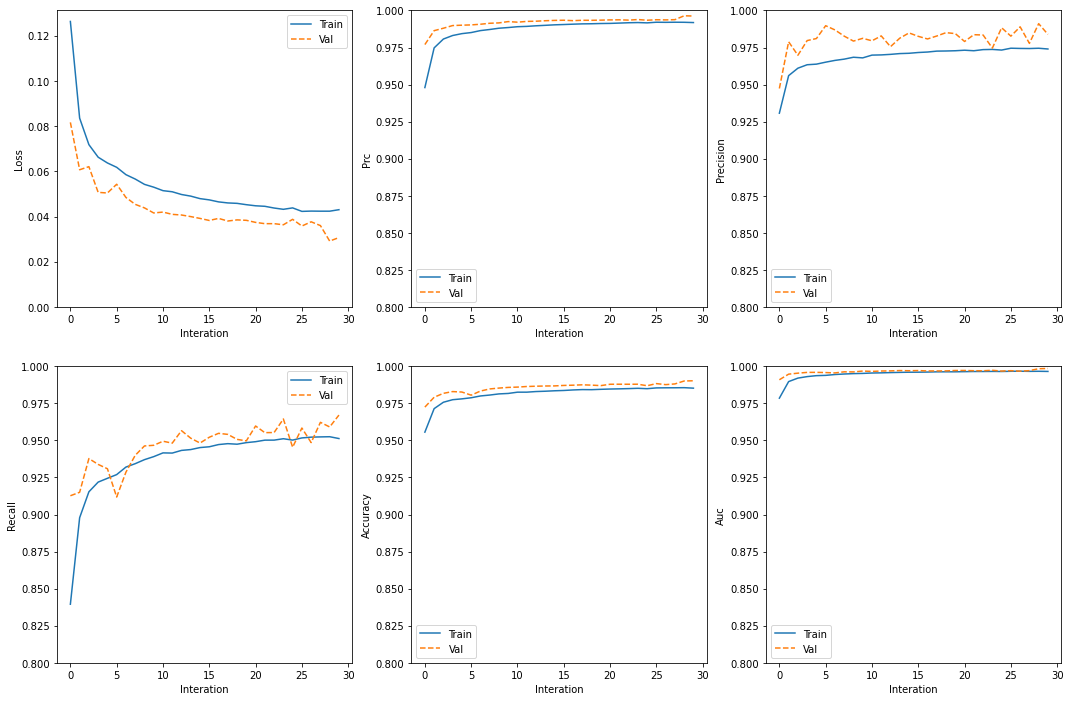

In [45]:
plot_metrics(history)

In [46]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

In [47]:
# plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
# plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')
# plt.legend(loc='lower right')

In [48]:
def convertPredToData(predictions, inputs):
    predicted_rows = []
    for idx, x in np.ndenumerate(inputs):
        label = 0
        if (predictions[idx] > 0.7):
            label = 1
        else:
            label = 0
        predicted_rows.append([x, label, predictions[idx] ])

    data = pd.DataFrame(predicted_rows, columns=["url", "label","confidence_score"])
    return data

In [49]:
# sample testing with 200 Random Records.
# get 200 sample records from 1M records.
x_test_sample = x_test.sample(frac=0.0014)

predictions = model.predict(x_test_sample)
df = convertPredToData(predictions, x_test_sample)

print(df)

                                                   url  label confidence_score
0                       transistics.com/transdc/Adobe/      0     [0.46533495]
1                                           ico.co.za/      0     [0.13523218]
2                                          clarke.com/      0    [0.020361466]
3                     www.ddj.com/architect/184415176/      0    [0.012082268]
4    https://www.montrealmosaic.com/article/montrea...      0  [1.0271403e-09]
..                                                 ...    ...              ...
253  https://www.tmz.com/2007/06/12/real-worlds-fra...      0   [3.658584e-06]
254  https://www.lenox.com/kate_spade_new_york/_/N-...      0  [0.00033066934]
255           http://spaziodecoraciones.cl/wells/Work/      1     [0.99764985]
256  https://www.klosterkaelderen.com/katindex.asp?...      0    [0.000996744]
257                      caryplayers.org/mattress.html      0   [0.0017881878]

[258 rows x 3 columns]


In [50]:
#model directory.
MODEL_DIR = "model_output"
model.save(MODEL_DIR)
estimator = tf.keras.estimator.model_to_estimator(keras_model=model, model_dir=MODEL_DIR)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

In [51]:
saved_model = tf.keras.models.load_model(MODEL_DIR)

# Check its architecture
saved_model.summary()

# fit loaded model
# history_loaded = saved_model.fit(train_dataset, epochs=NO_EPOCHS, validation_data=test_dataset)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, 200)          0           main_input[0][0]                 
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 200, 64)      14848       text_vectorization[0][0]         
__________________________________________________________________________________________________
sequential_10 (Sequential)      (None, 128)          17024       embedding_7[0][0]                
____________________________________________________________________________________________

In [ ]:
import flask
from flask import Flask
from werkzeug.wrappers import Request, Response
# initialize our Flask application and the Keras model
app = flask.Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    inputs = np.array(request.json)
    prediction = saved_model.predict(inputs)
    data_df = convertPredToData(predictions, inputs)
    return Response(data_df.to_json(orient="records"), mimetype='application/json')

if __name__ == '__main__':
    from werkzeug.serving import run_simple
    run_simple('localhost', 9000, app)

In [ ]:
import requests
BASE_URL = "http://127.0.0.1:9000"
payload = [ "https://www.facebook.com" , "hottraveljobs.com/forum/docs/info.php"]
request = requests.post("{}/predict".format(BASE_URL), json = payload)
request.raise_for_status()
response = request.json()
response

In [58]:
# Convert the model to TFLite format for mobile and other resource constrain devices.
SAVED_MODEL_DIR = "saved_model"

tf.saved_model.save(
    model,
    SAVED_MODEL_DIR)


converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_DIR)
converter.allow_custom_ops = True
tflite_model = converter.convert()


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

In [59]:
# Show model size in KBs.
float_model_size = len(tflite_model) / 1024
float_model_size_mb = float_model_size / 1024
print('The TF Light model size = %dKBs.' % float_model_size)
print('The TF Light model size = %dMBs.' % float_model_size_mb)

The TF Light model size = 2582KBs.
The TF Light model size = 2MBs.


In [60]:
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_DIR)
converter.allow_custom_ops = True
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_optimized_model = converter.convert()


In [62]:
# Show model size in KBs.
float_model_size = len(tflite_optimized_model) / 1024
float_model_size_mb = float_model_size / 1024
print('The TF Light model size = %dKBs.' % float_model_size)

The TF Light model size = 678KBs.


In [64]:
interpreter = tf.lite.Interpreter(model_content=tflite_optimized_model)

In [65]:
interpreter.allocate_tensors() # memory allocation for input and output tensors
input_tensor_index = interpreter.get_input_details()[0]["index"]
output = interpreter.tensor(interpreter.get_output_details()[0]["index"])

RuntimeError: Encountered unresolved custom op: MutableHashTableV2.Node number 0 (MutableHashTableV2) failed to prepare.
